# COGS 108 - Final Project 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [  ] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Kyle Huang
- Derek Tse
- Zhaoge Ouyang
- Cary Wang

# Group Members IDs

- A15747306
- A14136586
- A15405768
- A15071719

# Research Question

Can a game's genre, critic score, and gaming platform predict the popularity of a game(based on the # of sales)?

## Background and Prior Work

This question is interesting because:
We will be able to see the current trends in gaming.
When a game is released by a company, the critic score, the company its made by, and the genre can predict how well the game does in the market. These all influence the popularity of a game. So according to these variables, we want to predict how popular a game is and if it is worth playing. Recently some popular games such as among us and Genshin Impact have skyrocketed in popularity and sales, so we want to investigate what exactly makes games like this popular so fast.
References (include links):
- 1)https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.549.6080&rep=rep1&type=pdf
- 2)https://www.kaggle.com/gulsahdemiryurek/video-game-sales-exploratory-data-analysis

# Hypothesis


Our hypothesis is that games that fall into the adventure and strategy genres tend to have the highest sales(and therefore popularity) due to games in the two genres having more sales, higher critic scores, and a stronger focus on a single game console than games from other genres.

# Dataset(s)

- Dataset Name: Video Game Sales
- Link to the dataset: https://www.kaggle.com/gregorut/videogamesales
- Number of observations: 16598

According to the dataset description, this dataset encompasses sales data for video games that had greater than 100,000 copies sold. The dataset gives us sales data for US, Europe, Japan, and then rest of the world (in millions). The dataset is sorted by total sales, in decreasing order.

# Setup

Let's begin by importing some packages for analysis.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

Let's import the dataset listed for the analysis.

In [3]:
vgsales = pd.read_csv('vgsales.csv')
metacritic = pd.read_csv('metacritic_games.csv')

In [4]:
metacritic.head()

,game,platform,developer,genre,...,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,...,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,...,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,...,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,...,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,...,39,11,90,84


Merge the critic scores with the sales data.

In [5]:
metacritic.columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score'],
      dtype='object')

In [6]:
x = metacritic.merge(vgsales, left_on='game', right_on='Name')

To make sure that our data is imported properly:

In [7]:
vgsales.shape

(16598, 11)

In [8]:
vgsales.head()

,Rank,Name,Platform,Year,...,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,...,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,...,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,...,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,...,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,...,8.89,10.22,1.00,31.37


In [9]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

# Data Cleaning

Describe your data cleaning steps here.

In [10]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

The column labels are not clear, so we'll rename some of them. In the Kaggle page, sales are in units of millions. Year also refers to release year.

In [11]:
vgsales = vgsales.rename(columns=str.lower)
vgsales = vgsales.rename(columns={'year':'release_year', 'na_sales' : 'na_sales_million', 'eu_sales': 'eu_sales_million', 'jp_sales': 'jp_sales_million', 'other_sales': 'other_sales_million', 'global_sales': 'global_sales_million'})

Let's take a look at the platforms available. We won't use all of them for analysis (namely, we only use platforms that are released 2005 or later). We will store the platforms we will look at in the variable `platforms`.

In [12]:
vgsales['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [13]:
platforms = ['PC', 'DS', 'Wii', 'WiiU', '3DS', 'PS3', 'PS4', 'PSV', 'XB', 'X360', 'XOne']

We'll drop the rest.

In [14]:
vgsales['platform'] = vgsales['platform'].apply(lambda x: x if x in platforms else np.nan)
vgsales.dropna(subset=['platform'], inplace=True)

In [15]:
vgsales['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', '3DS', 'PS4', 'XB', 'PC', 'XOne',
       'WiiU', 'PSV'], dtype=object)

Finally, let's drop rows that are missing one or more data point for sales data.

In [16]:
vgsales = vgsales.dropna(subset=['eu_sales_million', 'jp_sales_million', 'na_sales_million', 'other_sales_million', 'global_sales_million'])

Let's see how many rows are we left with, after cleaning:

In [17]:
vgsales.shape

(9480, 11)

This is ready for data analysis.
Note: Some video games are released in multiple platforms. This dataset treats them as different observations.

# Data Analysis & Results

We have total of 9480 observations as shown.

In [18]:
vgsales.shape

(9480, 11)

We will be looking at variables name, platform, genre, and publisher.

In [19]:
variables = vgsales.loc[:, ['rank', 'name', 'platform', 'release_year', 'genre', 'publisher']]
variables = variables.dropna(subset=['rank', 'name', 'platform', 'release_year', 'genre', 'publisher'])
variables

,rank,name,platform,release_year,genre,publisher
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo
...,...,...,...,...,...,...
16591,16594,Myst IV: Revelation,PC,2004.0,Adventure,Ubisoft
16592,16595,Plushees,DS,2008.0,Simulation,Destineer
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES


vgsales.columns

In [20]:
sales = vgsales.loc[:, ['genre','na_sales_million', 'eu_sales_million', 'jp_sales_million','other_sales_million', 'global_sales_million']]
sales

,genre,na_sales_million,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million
0,Sports,41.49,29.02,3.77,8.46,82.74
2,Racing,15.85,12.88,3.79,3.31,35.82
3,Sports,15.75,11.01,3.28,2.96,33.00
...,...,...,...,...,...,...
16591,Adventure,0.01,0.00,0.00,0.00,0.01
16592,Simulation,0.01,0.00,0.00,0.00,0.01
16596,Puzzle,0.00,0.01,0.00,0.00,0.01


The max sale has a value that is far above the average sale across all sales columns, making the max sale an outlier as shown below.

In [21]:
sales.describe()

,na_sales_million,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million
count,9480.00,9480.00,9480.00,9480.00,9480.00
mean,0.26,0.16,0.05,0.05,0.53
std,0.82,0.60,0.26,0.18,1.68
...,...,...,...,...,...
50%,0.08,0.02,0.00,0.01,0.15
75%,0.24,0.12,0.02,0.04,0.45
max,41.49,29.02,6.50,8.46,82.74


In [22]:
na_sales_million = sales['na_sales_million']
na_sales_million = na_sales_million[na_sales_million < 40]
na_sales_million


2        15.85
3        15.75
6        11.38
         ...  
16591     0.01
16592     0.01
16596     0.00
Name: na_sales_million, Length: 9479, dtype: float64

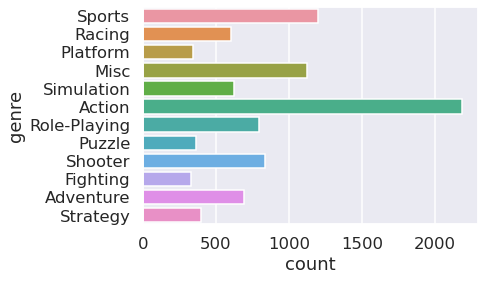

In [23]:
sns.countplot(y ='genre', data = vgsales)

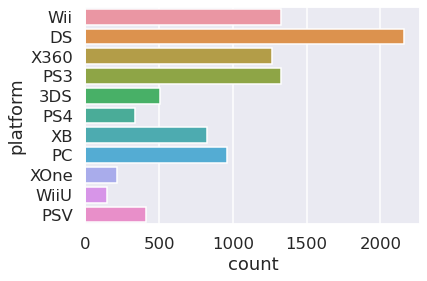

In [24]:
sns.countplot(y ='platform', data = vgsales)

From this graph we can see that most games are sold in North America, with the most made genre being action videogames.

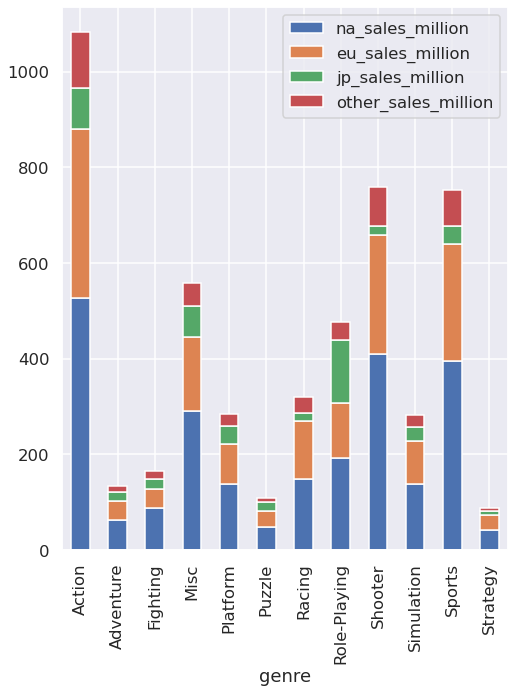

In [25]:
salesD = sales.groupby(['genre']).sum()
region = sales['genre'].unique()
salesD = salesD.drop(columns = ['global_sales_million'])
ax = salesD.plot.bar(stacked=True)
fig = plt.gcf()
fig.set_size_inches(8,10)

NA sales graph looks very simliar to the global sales graph since most of the sales are from here.

Text(0.5, 1.0, 'Videogame Sales by Genre North America 2000-2016')

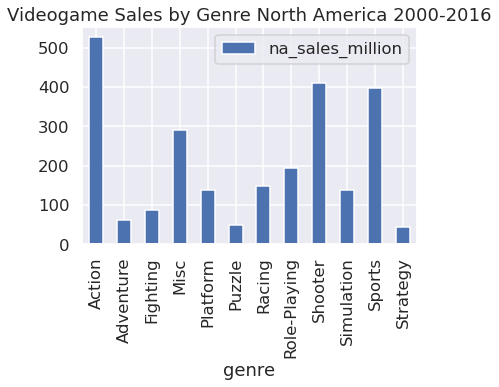

In [26]:
salesD = sales.groupby(['genre']).sum()
na = salesD.plot.bar(y = ['na_sales_million'])
plt.title('Videogame Sales by Genre North America 2000-2016')

Though Japan makes up a smaller portion of videogame sales globally, role playing games have the highest sales, rather than shooter, sports, and action games which have higher sales in other regions.

Text(0.5, 1.0, 'Videogame Sales by Genre Japan 2000-2016')

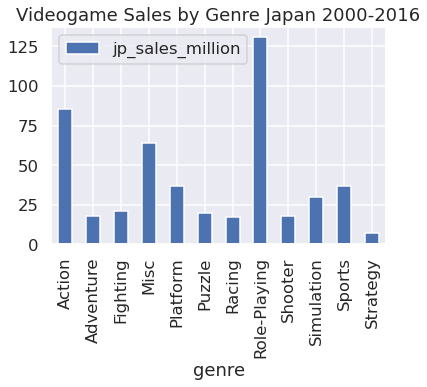

In [27]:

jp = salesD.plot.bar(y = ['jp_sales_million'])
plt.title('Videogame Sales by Genre Japan 2000-2016')

Sales in EU are very similar to NA, and also make up a decent portion of the total sales.

Text(0.5, 1.0, 'Videogame Sales by Genre Europe 2000-2016')

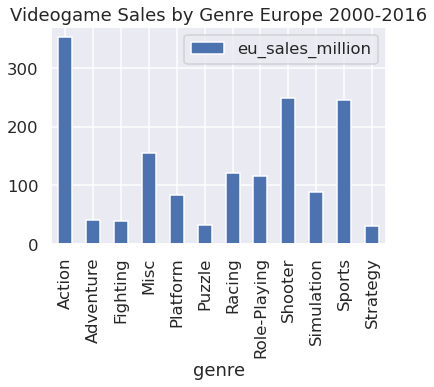

In [28]:
eu = salesD.plot.bar(y = ['eu_sales_million'])
plt.title('Videogame Sales by Genre Europe 2000-2016')

,rank,name,platform,release_year,...,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million
15867,15870,Strongest Tokyo University Shogi DS,DS,1985.0,...,0.00,0.02,0.00,0.02
14335,14338,Alter Ego,PC,1985.0,...,0.03,0.00,0.01,0.03
14507,14510,SimCity,PC,1988.0,...,0.02,0.00,0.01,0.03
...,...,...,...,...,...,...,...,...,...
16327,16330,Inversion,PC,NaN,...,0.00,0.00,0.00,0.01
16366,16369,Hakuouki: Shinsengumi Kitan,PS3,NaN,...,0.00,0.00,0.00,0.01
16493,16496,The Smurfs,3DS,NaN,...,0.01,0.00,0.00,0.01


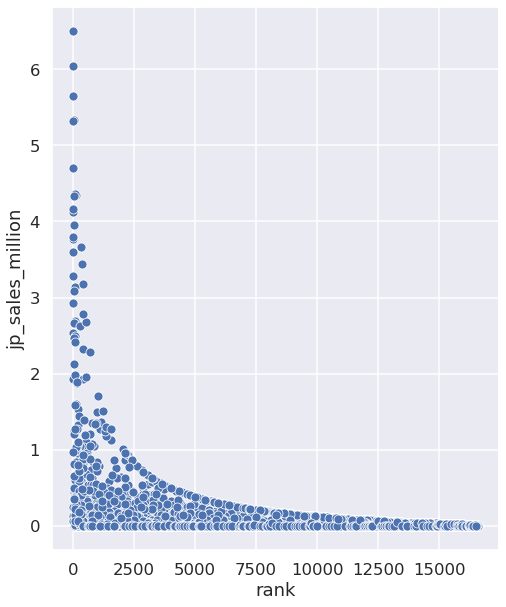

In [29]:
salesD = vgsales.sort_values(by='release_year')
sns.scatterplot(data=salesD, x="rank", y="jp_sales_million")
fig = plt.gcf()
fig.set_size_inches(8,10)
salesD

According to the graph, critic scores seem to be correlated with user scores, indicating that users generally agree with critics on if a game is good or not.

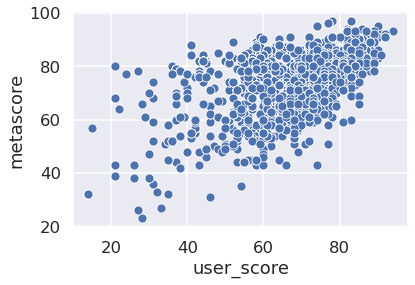

In [30]:
x = metacritic.merge(vgsales, left_on='game', right_on='name')
sns.scatterplot(data=x, x="user_score", y="metascore")

However, if we compare user score to total sales, there is little correlation. Some games that were given a really high user score did not have as much success as those games that have a lower score, and vice versa. The highest grossing games in this set have a score of about 82. People seem to still buy games even if they are rated poorly, and there are quit a few games that users gave high scores to, that did not sell so well.

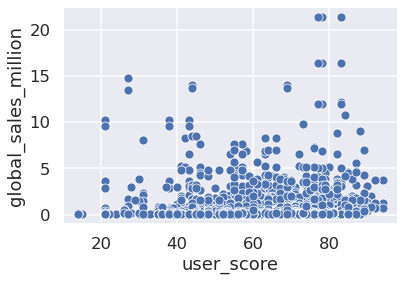

In [31]:
sns.scatterplot(data=x, x="user_score", y="global_sales_million")

In this case, there is a little more correlation between critic score and sales than the previous graph, which may suggest that critic score can influence how well a game sells.

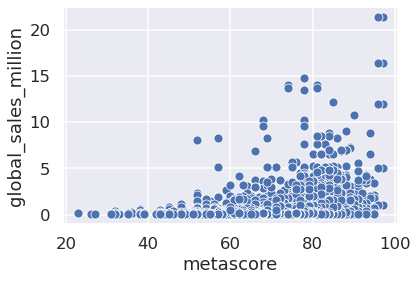

In [32]:
sns.scatterplot(data=x, x="metascore", y="global_sales_million")

In [38]:
s = sales.loc[:, ['genre', 'na_sales_million']]
s['rank'] = s['na_sales_million'].rank()

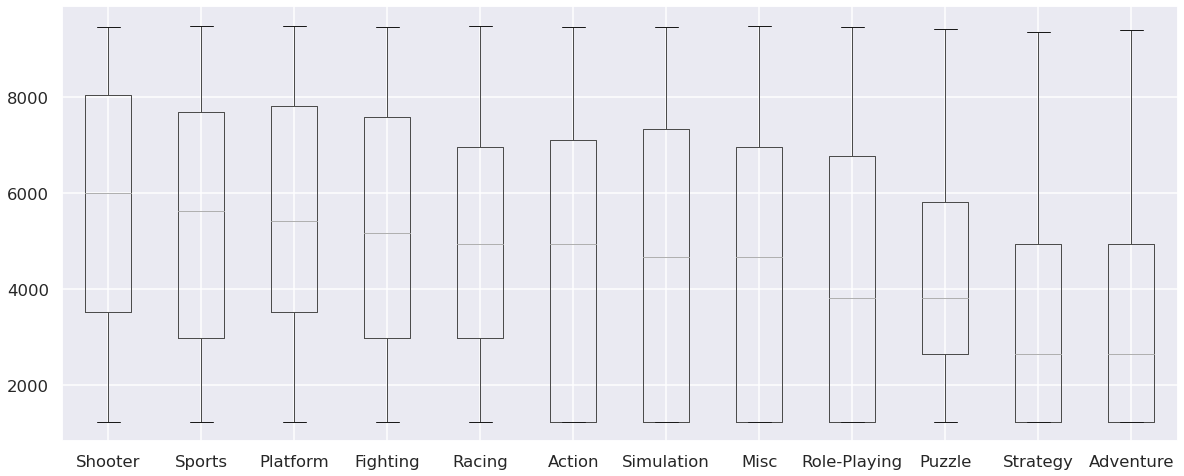

In [39]:
group = s.groupby('genre')
df2 = pd.DataFrame({col:vals['rank'] for col,vals in group})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]
df2.boxplot(figsize=(20,8))
plt.show()

# Ethics & Privacy

There are no PII involved with the data(as we are strictly dealing with public data in the gaming industry); therefore, this section is left blank.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*

Overview: Everyone

Data Cleaning: Derek